In [ ]:
#@title Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

In [4]:
#@title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 4), reused 7 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 639 bytes | 319.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   8e3d188..fbc971e  main       -> origin/main
Updating 8e3d188..fbc971e
Fast-forward
 src/quadruped_mjx_rl/training/fitting/optimization.py | 5 +++--
 1 file changed, 3 insertions(+), 2 deletions(-)


In [1]:
#@title Session setup

# Check if MuJoCo installation was successful
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Prepare configs
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs["unitree_go2"]()

from quadruped_mjx_rl.environments import JoystickBaseEnvConfig
env_config = JoystickBaseEnvConfig()

from quadruped_mjx_rl.models import ActorCriticConfig
model_config = ActorCriticConfig(
    modules = ActorCriticConfig.ModulesConfig(
        policy=[128, 128, 128, 128, 128],
        value=[256, 256, 256, 256, 256],
    ),
)

from quadruped_mjx_rl.training.configs import TrainingConfig
training_config = TrainingConfig(num_timesteps=1_000_000)

init_scene_path = scenes_path / "scene_mjx.xml"

from quadruped_mjx_rl.environments.physics_pipeline import load_to_spec, spec_to_model
env_model = spec_to_model(load_to_spec(init_scene_path))

from quadruped_mjx_rl.environments import resolve_env_class, get_env_factory
env_class = resolve_env_class(env_config)
env_model = env_class.customize_model(env_model, env_config)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_class=env_class,
    env_model=env_model,
)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


In [7]:
training_config.use_vision

(False,)

In [2]:
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Hello")

INFO:root:Hello


INFO:2025-08-25 15:30:39,738:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-25 15:30:39,744:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/m

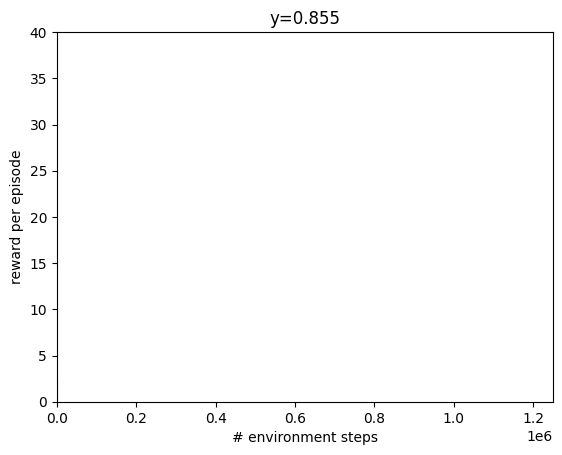

INFO:root:Setup took 27.759566068649292
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:{'eval/walltime': 159.7284278869629, 'eval/episode_reward': Array(0.855, dtype=float32), 'eval/episode_reward/action_rate': Array(-10.25, dtype=float32), 'eval/episode_reward/ang_vel_xy': Array(-28.637, dtype=float32), 'eval/episode_reward/feet_air_time': Array(-0.131, dtype=float32), 'eval/episode_reward/foot_slip': Array(-16.595, dtype=float32), 'eval/episode_reward/lin_vel_z': Array(-6.064, dtype=float32), 'eval/episode_reward/orientation': Array(-33.446, dtype=float32), 'eval/episode_reward/stand_still': Array(-1.472, dtype=float32), 'eval/episode_reward/termination': Array(-0.982, dtype=float32), 'eval/episode_reward/torques': Array(-3.089, dtype=float32), 'eval/episode_reward/tracking_ang_vel': Array(60.503, dtype=float32), 'eval/episode_reward/tracking_lin_vel': Array(50.715, dtype=float32), 'eval/episode_total_dist': Array(66.3

XlaRuntimeError: INVALID_ARGUMENT: layout minor_to_major field contains 1 elements, but shape is rank 0: {0}; shape: element_type: S32 layout { tail_padding_alignment_in_elements: 1 }

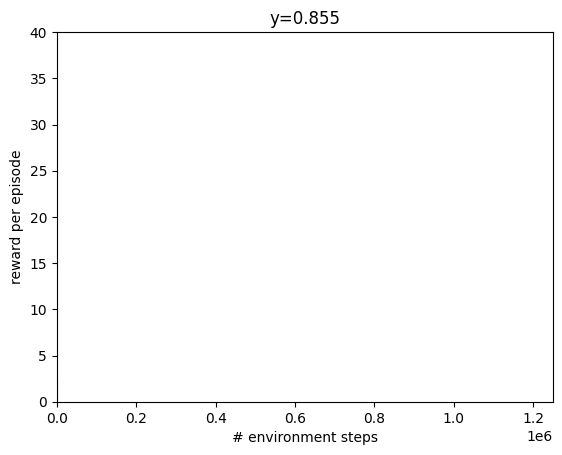

In [3]:
#@title Train the model
from quadruped_mjx_rl.training.train_interface import train
from quadruped_mjx_rl.domain_randomization.randomized_physics import domain_randomize
policy_factories, trained_params, evaluation_metrics = train(
    training_config=training_config,
    model_config=model_config,
    training_env=env_factory(),
    evaluation_env=env_factory(),
    randomization_fn=domain_randomize,
)